In [21]:
import pandas as pd
import numpy as np
import ast
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from collections import defaultdict
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, roc_auc_score, precision_recall_curve, auc
from xgboost import plot_importance
#import shap

### Read the CSV

In [22]:
test = pd.read_csv("/Users/svea/Documents/Stanford/Mitigating_bias_in_DL_models/final_data/densenet_test_embeddings.csv", quotechar='"', on_bad_lines='skip')
train = pd.read_csv("/Users/svea/Documents/Stanford/Mitigating_bias_in_DL_models/final_data/densenet_train_embeddings.csv", quotechar='"', on_bad_lines='skip')
valid = pd.read_csv("/Users/svea/Documents/Stanford/Mitigating_bias_in_DL_models/final_data/densenet_valid_embeddings.csv", quotechar='"', on_bad_lines='skip')

print(test.columns)
test.head()

Index(['path_to_image', 'path_to_dcm', 'age', 'sex', 'race', 'insurance_type',
       'No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly',
       'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia',
       'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other',
       'Fracture', 'Support Devices', 'embeddings'],
      dtype='object')


,path_to_image,path_to_dcm,age,sex,race,insurance_type,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,...,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,embeddings
0,train/patient47347/study3/view1_frontal.jpg,train/patient47347/study3/view1_frontal.dcm,78.0,1,0,1,0,0,1,0,...,1,0,0,1,0,1,0,1,1,"[0.0029132624622434378, 0.1020001769065857, 0...."
1,train/patient37527/study12/view1_frontal.jpg,train/patient37527/study12/view1_frontal.dcm,63.0,0,1,2,0,0,0,0,...,0,0,0,0,0,1,0,0,0,"[0.0014348188415169716, 0.0543656125664711, 0...."
2,train/patient41208/study9/view1_frontal.jpg,train/patient41208/study9/view1_frontal.dcm,70.0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,"[0.001982336398214102, 0.040021587163209915, 0..."
3,train/patient39357/study1/view1_frontal.jpg,train/patient39357/study1/view1_frontal.dcm,79.0,1,1,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,"[0.001741771469824016, 0.0560498870909214, 0.1..."
4,train/patient31982/study4/view1_frontal.jpg,train/patient31982/study4/view1_frontal.dcm,67.0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,"[9.678312198957428e-05, 0.12247737497091293, 0..."


### Convert embeddings from str to list (a bit long for large data sets)

In [23]:
test['embeddings'] = test['embeddings'].apply(ast.literal_eval)

In [24]:
train['embeddings'] = train['embeddings'].apply(ast.literal_eval)

### Remove columns

In [25]:
test = test.drop(columns=['path_to_image', 'path_to_dcm'])
train = train.drop(columns=['path_to_image', 'path_to_dcm'])


### Remove rows that were not processed (embeddings = 0)

In [26]:
initial_size = test.shape[0] 

# The previous logic with transforming the list to string and filtering on the length of said string is not necessarily stable and misleading.
# Let's implement a more explicit test for what we actually care about: 

test = test[test['embeddings'].apply(type) == list]

final_size = test.shape[0] 

print(f'Number of test removed rows = {initial_size - final_size}')

initial_size = train.shape[0] 

train = train[train['embeddings'].apply(type) == list]

final_size = train.shape[0] 

print(f'Number of train removed rows = {initial_size - final_size}')

Number of test removed rows = 51
Number of train removed rows = 67


### Convert age to binary to study bias

In [27]:
a = 70
test['age'] = (test['age'] >= a).astype(int)
#valid['age'] = (valid['age'] >= a).astype(int)
train['age'] = (train['age'] >= a).astype(int)

### Train test

In [28]:
train_embeddings = pd.DataFrame(train['embeddings'].tolist())
test_embeddings = pd.DataFrame(test['embeddings'].tolist())
#valid_embeddings = pd.DataFrame(valid['embeddings'].tolist())


# Diseases to predict
# diseases = ['Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia',
#             'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture']
diseases = ['Cardiomegaly', 'Lung Opacity', 'Edema', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion']
# diseases = ['Cardiomegaly', 'Lung Opacity', 'Edema', 'Pleural Effusion']

cath = ['age', 'sex', 'race', 'insurance_type']

# Labels for train and test
y_train = train[diseases]
y_test = test[diseases]

# Create x_train and x_test
x_train = pd.concat([train.reset_index(), train_embeddings], axis=1)
x_test =  pd.concat([test.reset_index(), test_embeddings], axis=1)

x_train.drop(columns=["embeddings"] + diseases, inplace=True)
x_test.drop(columns=["embeddings"] + diseases, inplace=True)



# Labels for train and test
y_train = train[diseases]
y_test = test[diseases]
#y_valid = valid[diseases]
y_no_finding = test["No Finding"]
y_sex = test['sex']
y_race = test['race']
y_insurance = test['insurance_type']
y_age = test['age']

train_cath = train[cath]
test_cath = test[cath]


In [29]:
x_train

,index,age,sex,race,insurance_type,No Finding,Enlarged Cardiomediastinum,Lung Lesion,Consolidation,Pneumonia,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0,0,0,0,1,0,0,0,0,0,...,0.0,0.265200,0.018271,0.311209,0.004827,0.010164,0.123856,0.036315,0.005551,0.092445
1,1,0,0,1,2,0,0,0,0,0,...,0.0,0.047433,0.019048,0.040865,0.022939,0.023320,0.020769,0.000000,0.013930,0.032231
2,2,1,0,0,1,0,0,0,0,0,...,0.0,0.195550,0.000292,0.092097,0.000124,0.000000,0.012944,0.012585,0.000000,0.003134
3,3,0,1,0,2,1,0,0,0,0,...,0.0,0.148768,0.006399,0.125957,0.062992,0.008402,0.060392,0.000313,0.001793,0.380946
4,4,0,1,0,1,0,0,0,0,0,...,0.0,0.055474,0.038927,0.119608,0.063662,0.058007,0.038353,0.074958,0.023320,0.059788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67191,67258,0,1,0,1,0,0,1,0,0,...,0.0,0.354716,0.004647,0.436875,0.001930,0.019146,0.168306,0.117422,0.051634,0.008407
67192,67259,1,0,0,1,0,0,0,0,0,...,0.0,1.027055,0.004654,0.491546,0.001860,0.000000,0.212853,0.000000,0.014939,0.000553
67193,67260,0,0,0,2,1,0,0,0,0,...,0.0,0.297898,0.000000,0.252987,0.004520,0.000000,0.048803,0.001527,0.001198,0.014644
67194,67261,1,0,2,1,0,0,0,0,0,...,0.0,0.779380,0.024519,0.544878,0.003128,0.026972,0.227386,0.000000,0.027119,0.000000


### PCA to reduce embeddings

In [30]:
# Step 1: Standardize the embeddings_list to have mean 0 and variance 1
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.stack(train_embeddings.values))
X_test_scaled = scaler.transform(np.stack(test_embeddings.values))

# Step 2: Set target variance threshold (e.g., 95%)
variance_threshold = 0.95

# Step 3: Fit PCA to determine the optimal number of components based on variance threshold
pca_full = PCA()
pca_full.fit(X_train_scaled)
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Step 4: Find the number of components that meets the variance threshold
optimal_components = np.argmax(cumulative_variance >= variance_threshold) + 1
print(f"Optimal number of components to retain {variance_threshold*100}% variance: {optimal_components}")

#95% variance means that the selected principal components (reduced dimensions) retain 95% of the total variability present in the original high-dimensional data.

Optimal number of components to retain 95.0% variance: 305


In [31]:
# Apply PCA if wanted
pca = PCA(n_components=optimal_components)
x_train_subset = pca.fit_transform(X_train_scaled)
x_test_subset = pca.transform(X_test_scaled)


In [32]:
train_cath = pd.get_dummies(train_cath, columns= ['age', 'sex', 'race', 'insurance_type'])
test_cath = pd.get_dummies(test_cath, columns= ['age', 'sex', 'race', 'insurance_type'])
train_cath = train_cath.astype('int')
test_cath = test_cath.astype('int')

In [33]:
x_train_subset = pd.DataFrame(x_train_subset) 
x_train_subset = x_train_subset.reset_index(drop=True)

x_test_subset = pd.DataFrame(x_test_subset)
x_test_subset = x_test_subset.reset_index(drop=True)

train_cath = train_cath.reset_index(drop=True)
test_cath = test_cath.reset_index(drop=True)

In [34]:
test_cath.columns

Index(['age_0', 'age_1', 'sex_0', 'sex_1', 'race_0', 'race_1', 'race_2',
       'insurance_type_0', 'insurance_type_1', 'insurance_type_2'],
      dtype='object')

In [35]:
columns_to_remove = ['age_1', 'sex_1', 'race_2', 'insurance_type_2']

# Drop these columns from the DataFrame
test_cath = test_cath.drop(columns=columns_to_remove)
train_cath = train_cath.drop(columns=columns_to_remove)

### Add the cathegories in the training and testing set

In [36]:
x_train_subset = pd.concat([train_cath, x_train_subset], axis=1)
x_test_subset = pd.concat([test_cath, x_test_subset], axis=1)

In [37]:
x_train_subset

,age_0,sex_0,race_0,race_1,insurance_type_0,insurance_type_1,0,1,2,3,...,295,296,297,298,299,300,301,302,303,304
0,1,1,1,0,0,1,13.176661,2.432126,-0.457243,-7.769527,...,0.180774,0.441655,-0.347679,-0.308018,0.265750,-0.553853,0.342401,-1.084571,-0.493605,-0.923580
1,1,1,0,1,0,0,-9.891466,0.859173,0.341570,5.364088,...,0.065427,-0.188038,-0.517702,-0.646977,-0.005285,0.825728,0.174875,0.438001,0.226322,-0.883672
2,0,1,1,0,0,1,-18.705509,9.468058,-10.037300,-4.222531,...,0.330430,-0.074332,-0.224590,0.807673,-0.652725,0.208883,0.452052,0.136058,-0.815982,0.349910
3,1,0,1,0,0,0,19.590418,-3.840863,-2.906075,-6.210735,...,0.601113,-0.459820,-0.023036,-0.564439,0.521932,-0.204240,0.406189,0.486166,-1.387485,0.115971
4,1,0,1,0,0,1,5.558868,-12.874069,9.275970,-3.755498,...,0.664990,-0.497204,0.531371,0.889231,-0.072920,0.037713,0.142632,-0.129837,0.455851,-0.083805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67191,1,0,1,0,0,1,18.838259,-6.415434,6.753741,-2.032186,...,0.546683,-0.144385,0.193650,-0.450309,0.772232,-0.352072,-0.858787,-0.145438,0.224293,0.024107
67192,0,1,1,0,0,1,-12.360030,4.537242,-2.088920,7.828038,...,0.789987,-0.999699,0.044560,-0.892104,0.539315,0.106454,-0.133262,-0.431056,-0.672683,-0.017314
67193,1,1,1,0,0,0,1.024817,19.306928,-2.861782,-8.144903,...,-0.572200,-0.737288,0.095693,0.147219,-0.530827,-0.315229,0.187443,-0.155856,1.170243,0.142959
67194,0,1,0,0,0,1,-6.527677,3.299355,4.574663,1.517789,...,0.208314,-0.218481,0.026469,-0.053160,0.576251,-0.498057,0.611682,0.595930,0.258514,0.382922


In [38]:
# diseases = ['Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 
#             'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 
#             'Pleural Effusion', 'Pleural Other', 'Fracture']
diseases = ['Cardiomegaly', 'Lung Opacity', 'Edema', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion']
# diseases = ['Cardiomegaly', 'Lung Opacity', 'Edema', 'Pleural Effusion']

### Training the model

In [39]:
def train_model(x_train, y_train, x_test, y_test, model):
    multi_output_model = MultiOutputClassifier(model)
    multi_output_model.fit(x_train, y_train)

    # Dictionary to hold the probabilistic predictions, if available
    y_test_preds_proba = {}
    #shap_values = {}

    # Check if the model supports probability predictions and compute SHAP values for each output
    if hasattr(model, "predict_proba"):
        for idx, estimator in enumerate(multi_output_model.estimators_):
            disease = diseases[idx]
            probs = estimator.predict_proba(x_test)
            y_test_preds_proba[disease] = probs[:, 1]

            # Create a SHAP explainer and compute SHAP values for each estimator
            #explainer = shap.Explainer(estimator, x_train)
            #shap_values[disease] = explainer(x_test)
    else:
        y_test_preds_proba = None
        #shap_values = None

    return y_test_preds_proba , multi_output_model #, shap_values, explainer

# Example usage with x_train_subset, y_train, x_test_subset, y_test, and diseases defined
xgb_model = XGBClassifier(
    use_label_encoder=False,      
    eval_metric='logloss',   
    learning_rate=0.1,
    random_state=42
)

y_pred, trained_multi_output_model  = train_model(
    x_train=x_train_subset, 
    y_train=y_train, 
    x_test=x_test_subset, 
    y_test=y_test, 
    model=xgb_model, 
)


/Users/svea/miniconda3/envs/mitigate-bias/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [12:50:01] WARNING: /var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_b6qk1lz_ug/croot/xgboost-split_1724073748391/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/svea/miniconda3/envs/mitigate-bias/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [12:50:08] WARNING: /var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_b6qk1lz_ug/croot/xgboost-split_1724073748391/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/svea/miniconda3/envs/mitigate-bias/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [12:50:16] WARNING: /var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_b6qk1lz_ug/croot/xgboost-split_1724073748391/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning

In [40]:
diseases = ['Cardiomegaly', 'Lung Opacity', 'Edema', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion']

In [41]:
#disease_name = 'Cardiomegaly' 
#feat_names = list(x_test_subset.columns)

#shap.summary_plot(shap_values[disease_name], feature_names=feat_names)




Feature Importance

<Figure size 640x480 with 0 Axes>

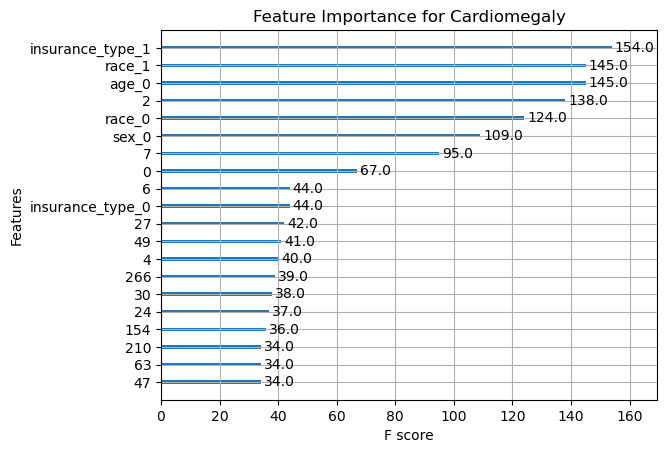

<Figure size 640x480 with 0 Axes>

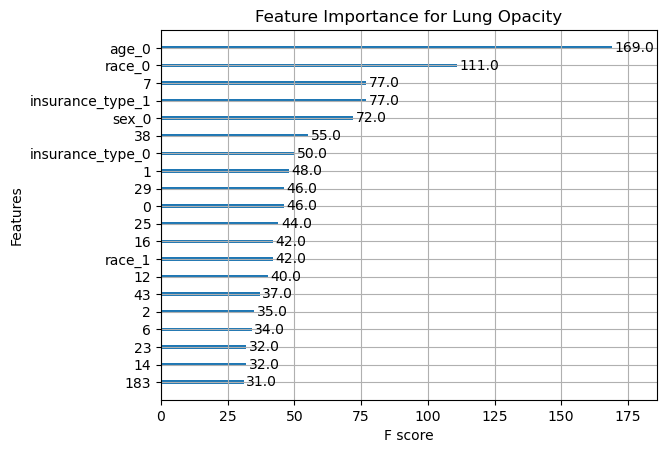

<Figure size 640x480 with 0 Axes>

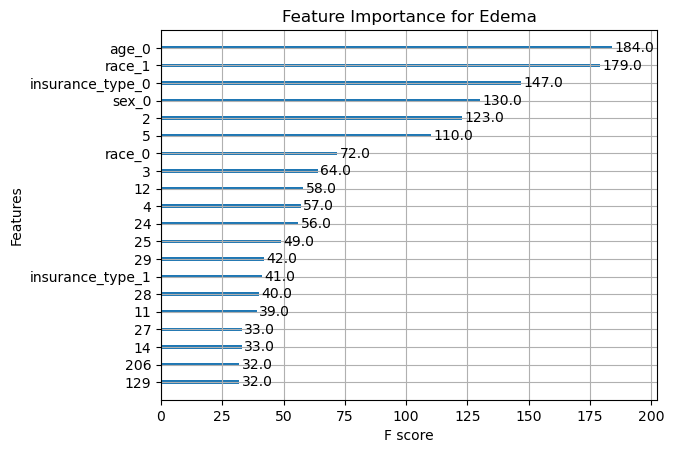

<Figure size 640x480 with 0 Axes>

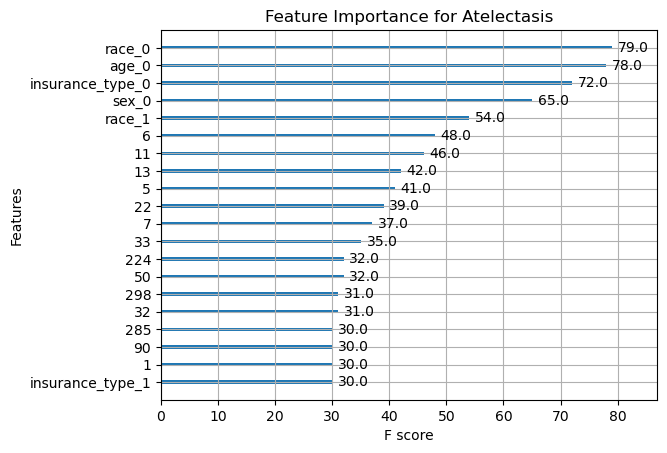

<Figure size 640x480 with 0 Axes>

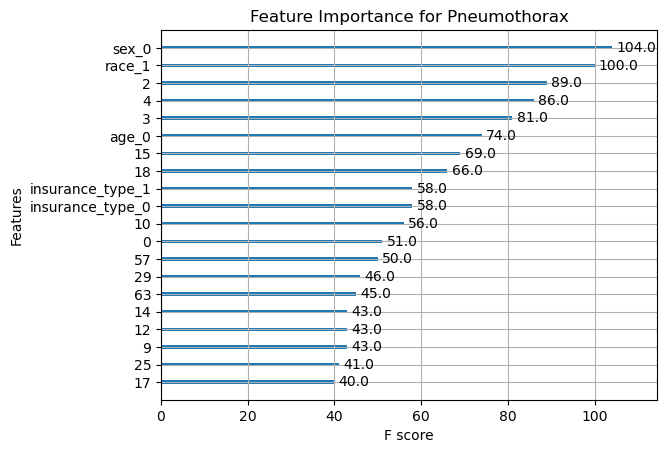

<Figure size 640x480 with 0 Axes>

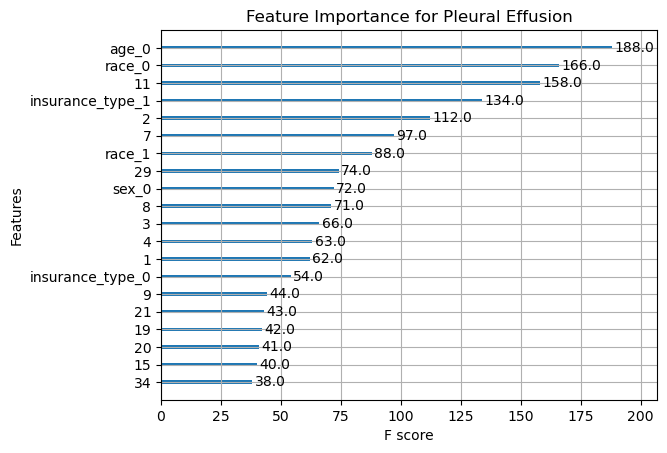

In [42]:
if hasattr(x_train_subset, 'columns'):
    feature_names = x_train_subset.columns.tolist()
else:
    feature_names = [f"Feature {i}" for i in range(x_train_subset.shape[1])]

# Plot für jeden Schätzer in MultiOutputClassifier mit den Feature-Namen auf der y-Achse
for idx, estimator in enumerate(trained_multi_output_model.estimators_):
    plt.figure()
    # Erstellen des Feature Importance Plots
    ax = plot_importance(estimator, max_num_features=20, title=f"Feature Importance for {diseases[idx]}")
    
    # Anpassen der y-Achsen-Beschriftungen zu den tatsächlichen Feature-Namen
    y_labels = [feature_names[int(label.get_text())] for label in ax.get_yticklabels()]
    ax.set_yticklabels(y_labels)
    
    plt.title(f"Feature Importance for {diseases[idx]}")
    plt.show()


In [43]:
predictions = y_pred.values
targets = y_test.values

In [44]:
predictions = np.transpose(np.stack(list(y_pred.values()), axis=0))
predictions

array([[0.10765221, 0.69319814, 0.47226405, 0.08552043, 0.08236567,
        0.70271343],
       [0.05969549, 0.6108305 , 0.29704586, 0.11370894, 0.08935814,
        0.5106411 ],
       [0.03622253, 0.3557296 , 0.06279469, 0.20038903, 0.09300657,
        0.18845469],
       ...,
       [0.04807736, 0.70545137, 0.21914648, 0.09707731, 0.11048226,
        0.3921341 ],
       [0.04622129, 0.32844564, 0.05600794, 0.13692908, 0.07925416,
        0.08715677],
       [0.02333008, 0.49173826, 0.05304927, 0.12591588, 0.43841797,
        0.38842478]], dtype=float32)

In [45]:
diseases = ['Cardiomegaly', 'Lung Opacity', 'Edema', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion']
# diseases = ['Cardiomegaly', 'Lung Opacity', 'Edema', 'Pleural Effusion']

In [46]:
def compute_metrics(predictions, targets):
    # Calculate metrics for each disease
    metrics = {}
    for idx, disease in enumerate(diseases):
        disease_pred = predictions[disease]
        disease_true = targets[disease]
        # disease_pred = predictions[:, idx]
        # disease_true = targets[:, idx]
        auc_roc = roc_auc_score(disease_true, disease_pred)
        f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
        accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
        tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
        tp_rate = tp / (tp + fn) if (tp + fn) > 0 else 0
        tn_rate = tn / (tn + fp) if (tn + fp) > 0 else 0
        fn_rate = fn / (fn + tp) if (fn + tp) > 0 else 0
        fp_rate = fp / (tn + fp) if (tn + fp) > 0 else 0
        
        # Calculate Precision-Recall AUC
        precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
        auprc = auc(recall, precision)

        metrics[disease] = {
            'Accuracy': accuracy,
            'AUC': auc_roc,
            'AUPRC': auprc,
            'F1 Score': f1,
            'TP Rate': tp_rate,
            'FN Rate': fn_rate,
            'TN Rate': tn_rate,
            'FP Rate': fp_rate
        }
    return metrics

metrics = compute_metrics(pd.DataFrame(y_pred), pd.DataFrame(y_test))
print(metrics)

{'Cardiomegaly': {'Accuracy': 0.8815590344108963, 'AUC': 0.80414832508485, 'AUPRC': 0.3905849265782171, 'F1 Score': 0.18309377138945926, 'TP Rate': 0.10786290322580645, 'FN Rate': 0.8921370967741935, 'TN Rate': 0.9901264605199875, 'FP Rate': 0.009873539480012449}, 'Lung Opacity': {'Accuracy': 0.6458679633810505, 'AUC': 0.6916347414539462, 'AUPRC': 0.6378454512628093, 'F1 Score': 0.6700263535068658, 'TP Rate': 0.7302963112275751, 'FN Rate': 0.2697036887724249, 'TN Rate': 0.5639935493329424, 'FP Rate': 0.4360064506670576}, 'Edema': {'Accuracy': 0.7762671496266157, 'AUC': 0.783915384106237, 'AUPRC': 0.5013494086085373, 'F1 Score': 0.3566842630903125, 'TP Rate': 0.2581311306143521, 'FN Rate': 0.7418688693856479, 'TN Rate': 0.940141075044086, 'FP Rate': 0.05985892495591405}, 'Atelectasis': {'Accuracy': 0.8461805641699953, 'AUC': 0.6185697761409303, 'AUPRC': 0.21470117430066052, 'F1 Score': 0.0009668063164679343, 'TP Rate': 0.0004838709677419355, 'FN Rate': 0.9995161290322581, 'TN Rate': 0.9

In [47]:

# Calculate metrics for each disease and for each class

metrics_female = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_sex == 1, idx]
    disease_true = targets[y_sex == 1, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)
    
    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    metrics_female[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate
        }
    
metrics_male = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_sex == 0, idx]
    disease_true = targets[y_sex == 0, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)

    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    metrics_male[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate
        }

metrics_white = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_race == 0, idx]
    disease_true = targets[y_race == 0, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)

    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    metrics_white[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate
        }
    
metrics_black = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_race == 2, idx]
    disease_true = targets[y_race == 2, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)

    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    metrics_black[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate
        }
    
metrics_asian = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_race == 1, idx]
    disease_true = targets[y_race == 1, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)

    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    metrics_asian[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate
        }
    

metrics_medicaid = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_insurance == 0, idx]
    disease_true = targets[y_insurance == 0, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)

    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    metrics_medicaid[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate
        }
    
metrics_medicare = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_insurance == 1, idx]
    disease_true = targets[y_insurance == 1, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)

    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    metrics_medicare[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate
        }
    
metrics_private = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_insurance == 2, idx]
    disease_true = targets[y_insurance == 2, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)

    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    metrics_private[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate
        }
    

metrics_young = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_age == 0, idx]
    disease_true = targets[y_age == 0, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)
    
    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    metrics_young[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate
        }
    
metrics_old = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_age == 1, idx]
    disease_true = targets[y_age == 1, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)

    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    metrics_old[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate
        }

In [49]:
# Initialize an empty list to store the data
data_sex = []

# Iterate over the diseases in the metrics dictionary
for disease, values in metrics.items():
    # Extract AUC and rates from dictionaries
    
    auprc_overall = values['AUPRC'] *100

    auc_overall = values['AUC'] *100
    auc_male = metrics_male[disease]['AUC'] *100
    auc_female = metrics_female[disease]['AUC'] *100
    tp_rate_male = metrics_male[disease]['TP Rate'] *100
    tp_rate_female = metrics_female[disease]['TP Rate'] *100
    fp_rate_male = metrics_male[disease]['FP Rate'] *100
    fp_rate_female = metrics_female[disease]['FP Rate'] *100
    
    # Calculate delta AUC and equality of odds
    delta_auc_sex = abs(auc_male - auc_female)
    eq_odds_sex = 0.5 * (abs(tp_rate_male - tp_rate_female) + abs(fp_rate_male - fp_rate_female))
    
    # Append to the data list
    data_sex.append([disease, auprc_overall, auc_overall, auc_male, auc_female, delta_auc_sex, eq_odds_sex])

# Create a DataFrame
df_sex = pd.DataFrame(data_sex, columns=['Disease', 'AUPRC', 'AUC', 'AUC_Male', 'AUC_Female', 'Delta AUC', 'EqOdds'])


# Styling the DataFrame
styled_df = df_sex.style.format({
    'AUC': "{:.3f}", 
    'AUPRC': "{:.3f}",
    'AUC_Male': "{:.3f}", 
    'AUC_Female': "{:.3f}",
    'Delta AUC': "{:.3f}",
    'EqOdds': "{:.3f}"
}).background_gradient(cmap='viridis', subset=['AUPRC', 'AUC', 'AUC_Male', 'AUC_Female', 'Delta AUC', 'EqOdds'])

# Display the styled DataFrame
styled_df


,Disease,AUPRC,AUC,AUC_Male,AUC_Female,Delta AUC,EqOdds
0,Cardiomegaly,39.058,80.415,80.615,80.046,0.569,1.499
1,Lung Opacity,63.785,69.163,69.195,69.125,0.070,0.292
2,Edema,50.135,78.392,78.495,78.269,0.226,1.948
3,Atelectasis,21.470,61.857,62.859,60.261,2.598,0.011
4,Pneumothorax,28.040,74.979,74.020,76.266,2.246,0.215
5,Pleural Effusion,70.424,80.892,80.817,81.003,0.186,0.623


In [50]:
# Initialize an empty list to store the data
data_race = []

# Iterate over the diseases in the metrics dictionary
for disease, values in metrics.items():
    auprc_overall = values['AUPRC'] *100
    auc_overall = values['AUC'] *100
    auc_groups = [
        metrics_white[disease]['AUC'] *100,
        metrics_black[disease]['AUC'] *100,
        metrics_asian[disease]['AUC'] *100
    ]
    tp_rates = [
        metrics_white[disease]['TP Rate'] *100,
        metrics_black[disease]['TP Rate'] *100,
        metrics_asian[disease]['TP Rate'] *100
    ]
    fp_rates = [
        metrics_white[disease]['FP Rate'] *100,
        metrics_black[disease]['FP Rate'] *100,
        metrics_asian[disease]['FP Rate'] *100
    ]

    # Calculate the maximum delta AUC
    delta_auc_race = max(abs(auc_groups[i] - auc_groups[j]) for i in range(len(auc_groups)) for j in range(i + 1, len(auc_groups)))

    # Calculate the maximum equality of odds
    eq_odds_race = max(
        0.5 * (abs(tp_rates[i] - tp_rates[j]) + abs(fp_rates[i] - fp_rates[j]))
        for i in range(len(tp_rates)) for j in range(i + 1, len(tp_rates))
    )

    # Append to the data list
    data_race.append([disease, auprc_overall, auc_overall] + auc_groups + [delta_auc_race, eq_odds_race])

# Create a DataFrame
columns = ['Disease', 'AUPRC', 'AUC', 'AUC_White', 'AUC_Black', 'AUC_Asian', 'Max Delta AUC', 'Max EqOdds']
df_race = pd.DataFrame(data_race, columns=columns)

# Display the DataFrame with styling
# Styling the DataFrame
styled_df = df_race.style.format({
    'AUC': "{:.3f}", 
    'AUPRC': "{:.3f}", 
    'AUC_White': "{:.3f}", 
    'AUC_Black': "{:.3f}",
    'AUC_Asian': "{:.3f}",
    'Max Delta AUC': "{:.3f}",
    'Max EqOdds': "{:.3f}"
}).background_gradient(cmap='viridis', subset=['AUPRC', 'AUC', 'AUC_White', 'AUC_Black', 'AUC_Asian', 'Max Delta AUC', 'Max EqOdds'])

# Display the styled DataFrame
styled_df

,Disease,AUPRC,AUC,AUC_White,AUC_Black,AUC_Asian,Max Delta AUC,Max EqOdds
0,Cardiomegaly,39.058,80.415,79.980,80.324,81.134,1.154,3.664
1,Lung Opacity,63.785,69.163,68.853,71.035,69.763,2.181,3.775
2,Edema,50.135,78.392,78.415,76.636,78.966,2.330,2.556
3,Atelectasis,21.470,61.857,61.970,58.879,61.971,3.092,0.130
4,Pneumothorax,28.040,74.979,74.333,76.945,76.804,2.612,1.119
5,Pleural Effusion,70.424,80.892,80.727,79.986,81.941,1.954,3.695


In [51]:
# Initialize an empty list to store the data
data_age = []

# Iterate over the diseases in the metrics dictionary
for disease, values in metrics.items():
    # Extract AUC and rates from dictionaries
    
    auprc_overall = values['AUPRC'] *100

    auc_overall = values['AUC'] *100
    auc_old = metrics_old[disease]['AUC'] *100
    auc_young = metrics_young[disease]['AUC'] *100
    tp_rate_old = metrics_old[disease]['TP Rate'] *100
    tp_rate_young = metrics_young[disease]['TP Rate'] *100
    fp_rate_old = metrics_old[disease]['FP Rate'] *100
    fp_rate_young = metrics_young[disease]['FP Rate'] *100
    
    # Calculate delta AUC and equality of odds
    delta_auc_age = abs(auc_old - auc_young)
    eq_odds_age = 0.5 * (abs(tp_rate_old - tp_rate_young) + abs(fp_rate_old - fp_rate_young))
    
    # Append to the data list
    data_age.append([disease, auprc_overall, auc_overall, auc_old, auc_young, delta_auc_age, eq_odds_age])

# Create a DataFrame
df_age = pd.DataFrame(data_age, columns=['Disease', 'AUPRC', 'AUC', 'AUC_old', 'AUC_young', 'Delta AUC', 'EqOdds'])


# Styling the DataFrame
styled_df = df_age.style.format({
    'AUC': "{:.3f}", 
    'AUPRC': "{:.3f}",
    'AUC_old': "{:.3f}", 
    'AUC_young': "{:.3f}",
    'Delta AUC': "{:.3f}",
    'EqOdds': "{:.3f}"
}).background_gradient(cmap='viridis', subset=['AUC', 'AUPRC', 'AUC_old', 'AUC_young', 'Delta AUC', 'EqOdds'])

# Display the styled DataFrame
styled_df


,Disease,AUPRC,AUC,AUC_old,AUC_young,Delta AUC,EqOdds
0,Cardiomegaly,39.058,80.415,77.160,81.645,4.485,0.960
1,Lung Opacity,63.785,69.163,65.221,70.997,5.775,9.692
2,Edema,50.135,78.392,76.377,79.226,2.848,4.283
3,Atelectasis,21.470,61.857,59.078,63.418,4.339,0.004
4,Pneumothorax,28.040,74.979,73.831,74.794,0.964,0.997
5,Pleural Effusion,70.424,80.892,80.213,81.201,0.988,6.275


In [53]:
# Initialize an empty list to store the data
data_health = []

# Iterate over the diseases in the metrics dictionary
for disease, values in metrics.items():
    auprc_overall = values['AUPRC'] *100
    auc_overall = values['AUC'] *100
    auc_groups = [
        metrics_medicaid[disease]['AUC'] *100,
        metrics_medicare[disease]['AUC'] *100,
        metrics_private[disease]['AUC'] *100
    ]
    tp_rates = [
        metrics_medicaid[disease]['TP Rate'] *100,
        metrics_medicare[disease]['TP Rate'] *100,
        metrics_private[disease]['TP Rate'] *100
    ]
    fp_rates = [
        metrics_medicaid[disease]['FP Rate'] *100,
        metrics_medicare[disease]['FP Rate'] *100,
        metrics_private[disease]['FP Rate'] *100
    ]

    # Calculate the maximum delta AUC
    delta_auc_health = max(abs(auc_groups[i] - auc_groups[j]) for i in range(len(auc_groups)) for j in range(i + 1, len(auc_groups)))

    # Calculate the maximum equality of odds
    eq_odds_health = max(
        0.5 * (abs(tp_rates[i] - tp_rates[j]) + abs(fp_rates[i] - fp_rates[j]))
        for i in range(len(tp_rates)) for j in range(i + 1, len(tp_rates))
    )

    # Append to the data list
    data_health.append([disease, auprc_overall, auc_overall] + auc_groups + [delta_auc_health, eq_odds_health])

# Create a DataFrame
columns = ['Disease', 'AUPRC', 'AUC', 'AUC_Medicaid', 'AUC_Medicare', 'AUC_Private', 'Max Delta AUC', 'Max EqOdds']
df_health = pd.DataFrame(data_health, columns=columns)

# Display the DataFrame with styling
# Styling the DataFrame
styled_df = df_health.style.format({
    'AUC': "{:.3f}", 
    'AUPRC': "{:.3f}", 
    'AUC_Medicaid': "{:.3f}", 
    'AUC_Medicare': "{:.3f}",
    'AUC_Private': "{:.3f}",
    'Max Delta AUC': "{:.3f}",
    'Max EqOdds': "{:.3f}"
}).background_gradient(cmap='viridis', subset=['AUPRC', 'AUC',  'AUC_Medicaid', 'AUC_Medicare', 'AUC_Private', 'Max Delta AUC', 'Max EqOdds'])

# Display the styled DataFrame
styled_df

,Disease,AUPRC,AUC,AUC_Medicaid,AUC_Medicare,AUC_Private,Max Delta AUC,Max EqOdds
0,Cardiomegaly,39.058,80.415,81.989,79.433,80.965,2.556,1.849
1,Lung Opacity,63.785,69.163,71.722,67.158,72.202,5.044,8.348
2,Edema,50.135,78.392,76.663,77.434,80.488,3.825,3.914
3,Atelectasis,21.470,61.857,62.861,60.141,65.322,5.181,0.117
4,Pneumothorax,28.040,74.979,74.796,74.440,74.459,0.357,0.702
5,Pleural Effusion,70.424,80.892,81.629,80.228,81.886,1.659,5.568


In [54]:
# Initialize an empty list to store the data
data = []
i=0
# Iterate over the diseases in the metrics dictionary
for disease, values in metrics.items():

    auprc_overall = values['AUPRC'] *100
    auc_overall = values['AUC'] *100

    # Append to the data list
    data.append([disease, auprc_overall, auc_overall] + [df_sex['Delta AUC'][i], df_sex['EqOdds'][i]] + [df_race['Max Delta AUC'][i], df_race['Max EqOdds'][i]] + [df_age['Delta AUC'][i], df_age['EqOdds'][i]] + [df_health['Max Delta AUC'][i], df_health['Max EqOdds'][i]])
    i+=1
# Create a DataFrame
columns = ['Disease', 'AUPRC', 'AUC', 'Delta AUC sex', 'EqOdds sex', 'Delta AUC race', 'EqOdds race', 'Delta AUC age', 'EqOdds age', 'Delta AUC health', 'EqOdds health']
df = pd.DataFrame(data, columns=columns)

# Display the DataFrame with styling
# Styling the DataFrame
styled_df = df.style.format({
    'AUC': "{:.3f}", 
    'AUPRC': "{:.3f}", 
    'Delta AUC sex': "{:.3f}", 
    'EqOdds sex': "{:.3f}",
    'Delta AUC race': "{:.3f}", 
    'EqOdds race': "{:.3f}",
    'Delta AUC age': "{:.3f}", 
    'EqOdds age': "{:.3f}",
    'Delta AUC health': "{:.3f}", 
    'EqOdds health': "{:.3f}"
}).background_gradient(cmap='Reds', subset=['AUC',  'AUPRC', 'Delta AUC sex', 'EqOdds sex', 'Delta AUC race', 'EqOdds race', 'Delta AUC age', 'EqOdds age', 'Delta AUC health', 'EqOdds health'])

# Display the styled DataFrame
styled_df

,Disease,AUPRC,AUC,Delta AUC sex,EqOdds sex,Delta AUC race,EqOdds race,Delta AUC age,EqOdds age,Delta AUC health,EqOdds health
0,Cardiomegaly,39.058,80.415,0.569,1.499,1.154,3.664,4.485,0.960,2.556,1.849
1,Lung Opacity,63.785,69.163,0.070,0.292,2.181,3.775,5.775,9.692,5.044,8.348
2,Edema,50.135,78.392,0.226,1.948,2.330,2.556,2.848,4.283,3.825,3.914
3,Atelectasis,21.470,61.857,2.598,0.011,3.092,0.130,4.339,0.004,5.181,0.117
4,Pneumothorax,28.040,74.979,2.246,0.215,2.612,1.119,0.964,0.997,0.357,0.702
5,Pleural Effusion,70.424,80.892,0.186,0.623,1.954,3.695,0.988,6.275,1.659,5.568


In [55]:
df.to_csv("xgboost_with_cath.csv")